This notebook explores the data used for benchmarking. It includes:

1. Using dataloader to ease ML training/inference pipeline
2. TBD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import xarray as xr
import numpy as np
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils
import logging
logging.basicConfig(level=logging.INFO)

We first initialize our S2S dataset, including 
1. ERA5 observations
2. Benchmark targets (one of NCEP, CMA, ECMWF, UKMO forecast centers)

In [3]:
# Initialize observations dataset by specifying the training/validation years
train_years = np.arange(1979, 2016)
val_years = test_years = np.arange(2016, 2023)
train_dataset = dataset.S2SObsDataset(years=train_years)
val_dataset = dataset.S2SObsDataset(years=val_years)

In [4]:
# Now we initialize our benchmark target by specifying the forecasting center by its abbreviations (ncep, cma, ecmwf, ukmo)
test_dataset = dataset.S2SEvalDataset(s2s_name='cma', years=test_years)

We perform sanity check by visualizing the observational ERA5 dataset

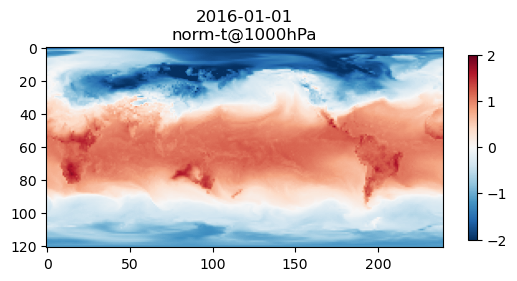

In [5]:
# Visualize input ERA5 features (eg. normalized surface temperature)
time_idx = 0
param = 't'
level = 1000

timestamp, val_x, val_y = val_dataset[time_idx]

plt.imshow(
    val_x[
        config.PARAMS.index(param),
        config.PRESSURE_LEVELS.index(level)
    ],
    cmap='RdBu_r', vmin=-2, vmax=2
)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\nnorm-{param}@{level}hPa')
plt.show();

In [6]:
# One snapshot of ERA5 observation has the following shape: (param, level, lat, lon)
val_x.shape

torch.Size([6, 10, 121, 240])

Now we visualize and check the shape of our benchmark data..

In [7]:
timestamp, test_data = test_dataset[time_idx]

test_data.shape

torch.Size([45, 6, 10, 121, 240])

Notice that we have an additional dimension in the first-axis (ie. size = 45). This indicates the forecasting step, where the first one indicates the present prediction, incremented every 24-hour (1-day) for 44 days ahead.

We can visualize this more clearly in the following figure...

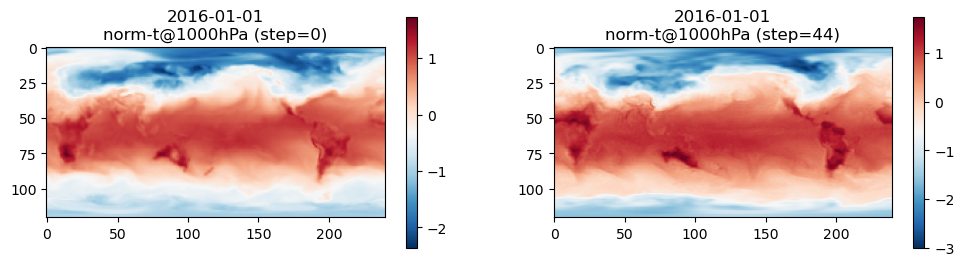

In [8]:
# Visualize s2s benchmark dataset

step_start = 0
step_end = test_data.shape[0] - 1

## Plot
f, ax = plt.subplots(1,2,figsize=(12,6))

im0 = ax[0].imshow(test_data[step_start][config.PARAMS.index(param),config.PRESSURE_LEVELS.index(level)],cmap='RdBu_r')
ax[0].set_title(f'{utils.convert_time(timestamp)}\nnorm-{param}@{level}hPa (step={step_start})')
cbar0 = f.colorbar(im0, ax=ax[0], shrink=0.5)

im1 = ax[1].imshow(test_data[step_end][config.PARAMS.index(param),config.PRESSURE_LEVELS.index(level)],cmap='RdBu_r')
ax[1].set_title(f'{utils.convert_time(timestamp)}\nnorm-{param}@{level}hPa (step={step_end})')
cbar1 = f.colorbar(im1, ax=ax[1], shrink=0.5)

plt.show();